In [1]:
import sys
sys.path.append('../')

import thermonets as tn
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
from nrlmsise00 import msise_flat
import cartopy.crs as ccrs

The EOP file 'finals2000A.all' in /Users/ga00693/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/ga00693/src/iers/ is already the latest.


### 1 - Load the dataset

In [2]:

# Here we the db the model was trained upon.
#note that columns can be (len 16):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'wind zonal [m/s]', 'wind meridional [m/s]', 'density [kg/m^3]'
#or (len 14):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'density [kg/m^3]'
db=np.loadtxt('../dbs/nrlmsise00_db.txt',delimiter=',',skiprows=1)
np.random.shuffle(db)
print(f'Shape of database is: {db.shape}')

Shape of database is: (999700, 16)


### 2 - Perform model inference

In [3]:
from tqdm import tqdm
#we extract the target density:
true=db[:,-1]
#and now we do inference and extract the predicted one:
predicted=[]
for item in tqdm(db):
    date=datetime.datetime(year=int(item[2]), 
                            month=int(item[1]), 
                            day=int(item[0]),
                            hour=int(item[3]),
                            minute=int(item[4]),
                            second=int(item[5]),
                            microsecond=int(item[6]))
    doy=date.timetuple().tm_yday
    sid=item[3]*3600+item[4]*60+item[5]+item[6]/1e6
    predicted.append(tn.nrlmsise00_tn(hs=item[7],lons=np.deg2rad(item[9]),lats=np.deg2rad(item[8]),f107a=item[10],f107=item[11],ap=item[12],doy=doy,sid=sid))
predicted=np.array(predicted).flatten()

100%|██████████| 999700/999700 [01:09<00:00, 14460.67it/s]


In [4]:
#now the global fit:
predicted_global_fit=tn.rho_approximation(h=db[:,7], params=tn.best_global_fit_nrlmsise00, backend='numpy')
rel_err_global_fit = ((predicted_global_fit - true) / true) * 100


In [5]:
rel_err = ((predicted - true) / true) * 100
rel_err_global_fit = ((predicted_global_fit - true) / true) * 100

print("MAPE from NN model: ", np.mean(np.abs(rel_err)))
print("MAPE from Global Fit model: ", np.mean(np.abs(rel_err_global_fit)))

MAPE from NN model:  2.604260823280932
MAPE from Global Fit model:  58.87458654626681


### 3 - Plots of the errors 

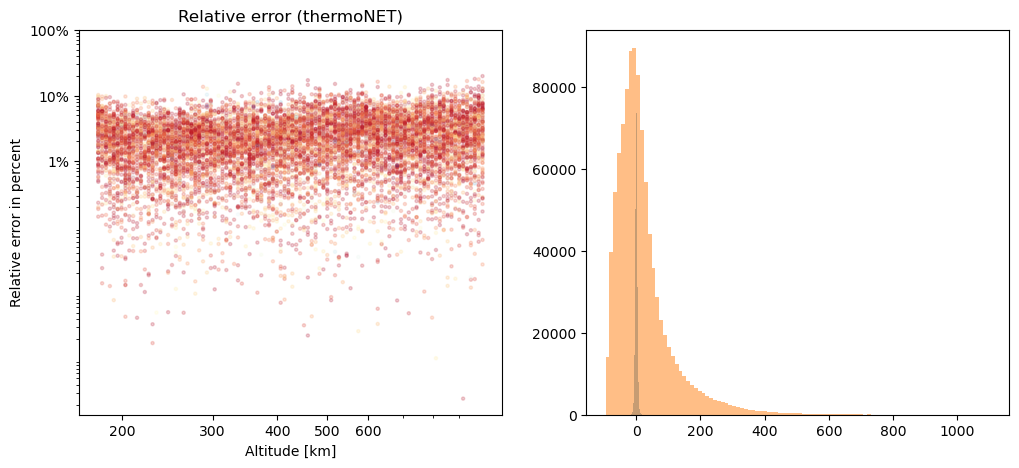

In [6]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
cm = plt.colormaps['RdYlBu']

rel_err = ((predicted - true) / true) * 100

c = (db[::99,11]+1)/2
sc = ax[0].scatter(db[::99, 7], np.abs(rel_err[::99]), alpha=0.2, c=c, s=5, cmap=cm)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_yticks([1, 10, 100], ["1%", "10%", "100%"])
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[0].set_title("Relative error (thermoNET)")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Relative error in percent")


#
ax[1].hist(rel_err, bins = 100, density=False, alpha=0.5);
ax[1].hist(rel_err_global_fit, bins = 100, density=False, alpha=0.5);

### 4 - Thermospheric map error

In [7]:
# We first establish the longitude latitude grid thickness
n_grid=400

# Altitude in km
alt = 200.

# Date
date = datetime.datetime(2018, 4, 22, 6, 13, 35)


In [16]:
# We build the model entries:
u,v= np.linspace(0,1,n_grid), np.linspace(0,1,n_grid)
longitude,latitude=np.sort(2*np.pi*u), np.sort(np.arccos(2*v-1)-np.pi/2)
lonlat_grid=np.stack([*np.meshgrid(longitude,latitude,indexing='ij')],axis=2).reshape(-1,2) #we generate the matrix of latitude longitude points (for msise_flat)
ap,f107,f107a, doy,sid = tn.get_nrlmsise00_attributes(date)
#we extract the target density (running NRLMSISE-00):
true = msise_flat(time=date, 
                          alt=alt, 
                          lon=np.rad2deg(lonlat_grid[:,0]), 
                          lat=np.rad2deg(lonlat_grid[:,1]), 
                          f107a=f107a, 
                          f107=f107, 
                          ap=ap)[:,5]*1e3
# Compute the inference of the model over the entire dataset
predicted = tn.nrlmsise00_tn(hs=[alt],lons=longitude, lats=latitude, f107a=f107a, f107=f107, ap=ap, doy=doy, sid=sid)

Average absolute relative percentage error on globe map: 1.7414558937038036 %


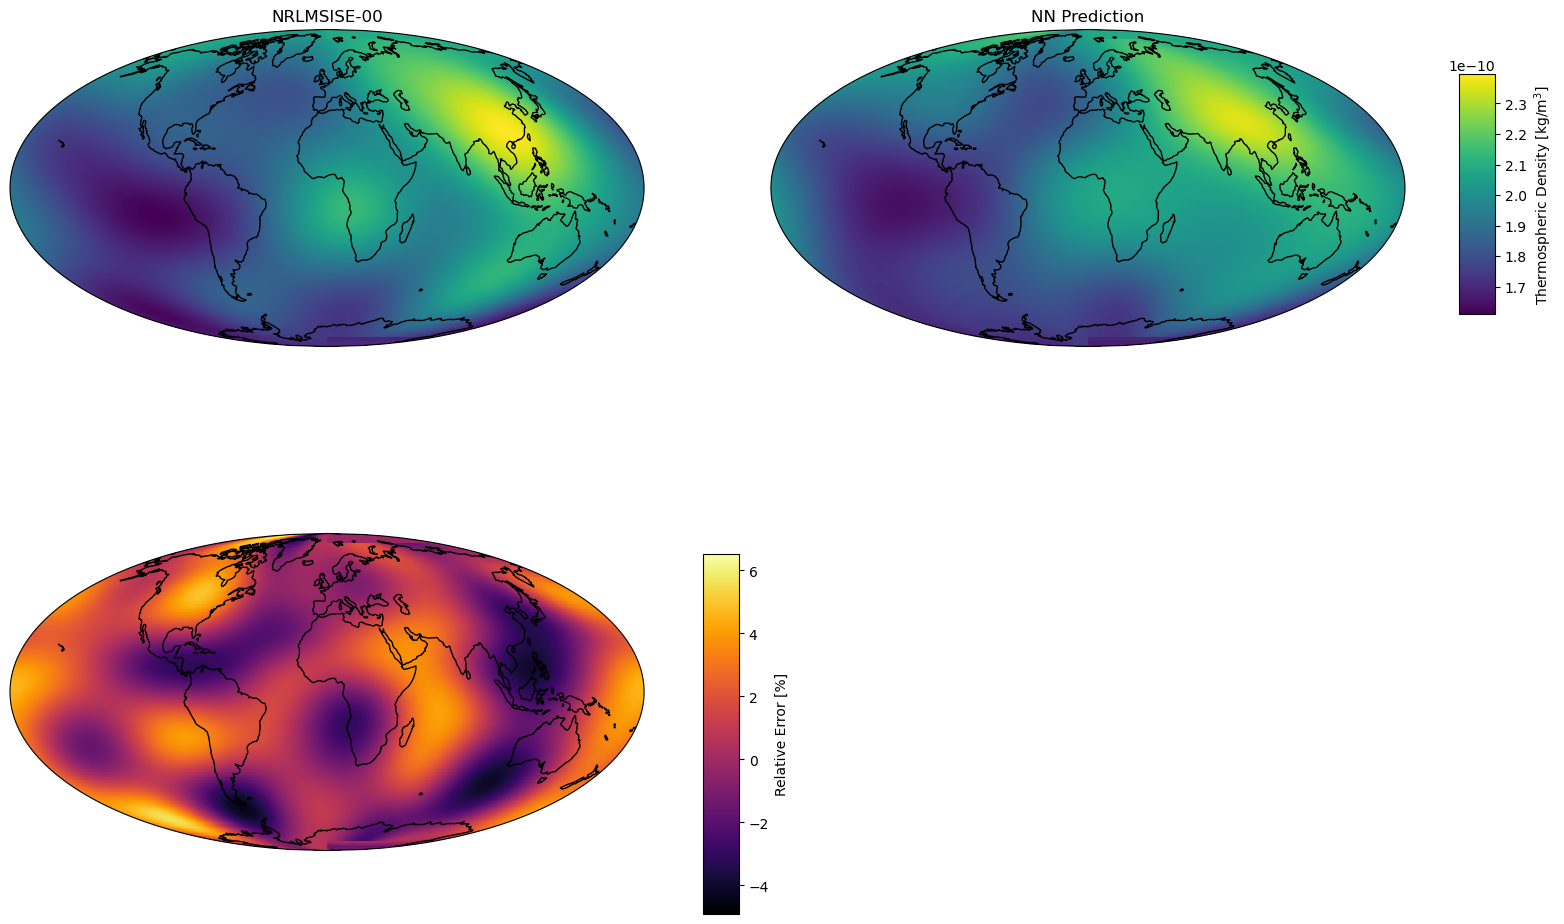

In [18]:
#we setup the longitude x latitude grid, and compute the relative error (in %)
lon_grid=np.rad2deg(lonlat_grid[:,0].reshape((n_grid,n_grid)))
lat_grid=np.rad2deg(lonlat_grid[:,1].reshape((n_grid,n_grid)))
rel_err = ((predicted.flatten() - true) / true) * 100
#we print to scree the mean absolute percentage error on the globe map:
print(f'Average absolute relative percentage error on globe map: {abs(rel_err).mean()} %')
#we now store the minimum and maximum density values (between target & prediction), for plotting purposes:
vmin=min([true.min(), predicted.min().item()])
vmax=max([true.max(), predicted.max().item()])

#we now create a figure with a globe projection on top:
fig, ax = plt.subplots(figsize=(18, 12), nrows=2, ncols=2, subplot_kw={'projection': ccrs.Mollweide(central_longitude=0)})
#we flatten the axis and remove the last figure
ax=ax.ravel()
ax[-1].axis('off')

#we plot NRLMSISE-00 on the first figure:
ax[0].pcolormesh(lon_grid, 
                        lat_grid, 
                        true.reshape((n_grid,n_grid)), transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax)
ax[0].set_global()
ax[0].coastlines()
#ax[0].gridlines()
ax[0].set_title('NRLMSISE-00')

#the NN prediction on the second:
im2 = ax[1].pcolormesh(lon_grid, 
                        lat_grid, 
                        predicted.reshape((n_grid,n_grid)), 
                        transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax)
ax[1].set_global()
ax[1].coastlines()
#ax[1].gridlines()
ax[1].set_title('NN Prediction')
#we add a shared colorbar for the first two figures:
cax1 = fig.add_axes([0.93, 0.6, 0.02, 0.2])  # [left, bottom, width, height]
cbar1 = plt.colorbar(im2, 
                     orientation='vertical', 
                     fraction=0.035,
                     cax=cax1)
cbar1.set_label('Thermospheric Density [kg/m$^3$]')

#we finally plot the relative error in the second row
im3 = ax[2].pcolormesh(lon_grid, 
                        lat_grid, 
                        rel_err.reshape((n_grid,n_grid)), 
                        transform=ccrs.PlateCarree(),
                        cmap='inferno')
ax[2].set_global()
ax[2].coastlines()
#ax[2].gridlines()
#and we add the colorbar for that:
cax2 = fig.add_axes([0.51, 0.1, 0.02, 0.3])  # [left, bottom, width, height]
cbar1 = plt.colorbar(im3, 
                     orientation='vertical', 
                     fraction=0.035,
                     cax=cax2)
cbar1.set_label('Relative Error [%]')